# Analyse de la complexité syntaxique des tweets en anglais et dans d’autres langues

**Auteur** : Caux Wedrik-Odal

**Date** : 17 janvier 2025

# 1. Introduction

Pour ce projet, j’ai décidé d’explorer une question qui m’intéresse particulièrement : comment la complexité syntaxique varie-t-elle dans les tweets publiés en anglais par rapport aux autres langues ? Les tweets, avec leur format limité à 280 caractères, imposent des contraintes uniques qui influencent la structure des phrases. Cela m’a donné envie de comparer l'anglais à d'autres langues pour voir comment elles s’adaptent à ce format.

Dans cette analyse, je m’intéresse à la complexité syntaxique, que je mesure à travers deux indicateurs :

1. Le nombre de relations syntaxiques (dependency count) : c’est-à-dire combien de mots dépendent les uns des autres dans une phrase.

2. La profondeur de l’arbre syntaxique (tree depth) : qui représente le nombre de niveaux hiérarchiques contenus dans une phrase, souvent plus élevés dans les phrases complexes.

Mon objectif est de répondre à deux grandes questions :

1.	Les tweets en anglais présentent-ils une syntaxe plus ou moins complexe que ceux rédigés dans d’autres langues ?

2.	Comment la contrainte des 280 caractères influence-t-elle la manière dont les utilisateurs construisent leurs phrases ?

# 2. Importation des librairies

In [1]:
# 0n importe les librairies et bibliothèques nécessaire pour l'étude
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
from collections import Counter
from scipy.stats import mannwhitneyu

# 3. Importation des données

On importe le dataset repértoriant des milliers de tweet en plusieurs langues récolté sur kaggle 

In [2]:
df = pd.read_csv("all_annotated.tsv", sep = "\t")
display(df)

,Tweet ID,Country,Date,Tweet,Definitely English,Ambiguous,Definitely Not English,Code-Switched,Ambiguous due to Named Entities,Automatically Generated Tweets
0,434215992731136000,TR,2014-02-14,Bugün bulusmami lazimdiii,0,0,1,0,0,0
1,285903159434563584,TR,2013-01-01,Volkan konak adami tribe sokar yemin ederim :D,0,0,1,0,0,0
2,285948076496142336,NL,2013-01-01,Bed,1,0,0,0,0,0
3,285965965118824448,US,2013-01-01,I felt my first flash of violence at some fool...,1,0,0,0,0,0
4,286057979831275520,US,2013-01-01,Ladies drink and get in free till 10:30,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
10497,774941788247298050,TR,2016-09-11,"I'm at @PiazzaAvym in Canik, Samsun w/ @mertar...",1,0,0,0,0,1
10498,774951242422480897,PH,2016-09-11,"El Nido, fica ao norte de Palawan, uma das ilh...",0,0,1,0,0,0
10499,774960083721531392,ID,2016-09-11,Alhamdulillah 😊👨‍👩‍👧‍👧🎂🍦makasih mah pah #lovyu...,0,0,1,0,0,0
10500,775057244798849024,NG,2016-09-11,Eid-Mubarak @ Bauchi Fedral Lowcost https://t....,0,1,0,0,1,0


# 4. Manipulation des données 

In [3]:
# On nettoie le dataset afin de supprimer les éléments pas important des tweets
def clean_tweet(text):
    """
    Cleans a tweet by removing hashtags, mentions, and URLs while keeping meaningful elements intact.
    """
    # On enlève les mentions (@username)
    text = re.sub(r"@\w+", "", text)
    
    # On supprime les hashtags mais on garde les mots (#exemple -> exemple)
    text = re.sub(r"#", "", text)
    
    # On supprime les liens
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    
    # On supprime les espaces supplémentaires
    text = re.sub(r"\s+", " ", text).strip()
    return text

# On applique la fonction 'cleaned_text'
df["cleaned_text"] = df["Tweet"].apply(clean_tweet)

# 5. Représentation des données

### 5.1 Distribution des tweets par catégorie linguistique

/var/folders/bd/qbh7t7450_g8p85v95frqnl40000gn/T/ipykernel_87209/698040603.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(language_counts.keys()), y=list(language_counts.values()), palette='deep')


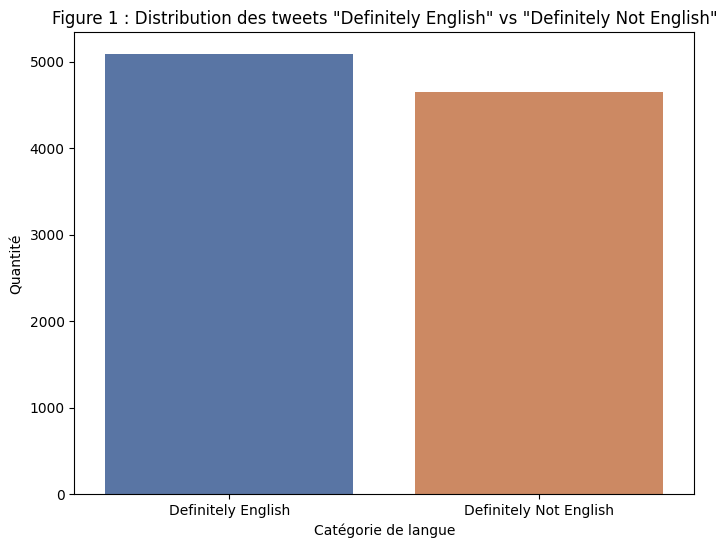

In [4]:
# On représente la distribution de tweets en anglais VS ceux pas anglais
    # On compte le nombre de tweets par catégories
language_counts = {
        'Definitely English': df['Definitely English'].sum(),
        'Definitely Not English': df['Definitely Not English'].sum()
    }
    
    # On crée le barplot représentant cette distribution

plt.figure(figsize=(8, 6))
sns.barplot(x=list(language_counts.keys()), y=list(language_counts.values()), palette='deep')
plt.title('Figure 1 : Distribution des tweets "Definitely English" vs "Definitely Not English"')
plt.xlabel('Catégorie de langue')
plt.ylabel('Quantité')
plt.show()

### 5.2 Analyse et visualisation de la complexité syntaxique

In [5]:
# On va analyser la complexité syntaxique en utilisant SpaCy
# On charge SpaCy qui est une bibliothèque de traitement du langage naturel fournissant des outils pour analyser et manipuler du texte écrit
nlp = spacy.load("en_core_web_sm")

def analyze_syntactic_complexity(text):
    """
    Analyse la complexité syntaxique d'un texte donné à l'aide de SpaCy.
    Retourne des métriques comme le nombre de dépendances (dependency_count) et la profondeur de l'arbre syntaxique (tree_depth).
    """
    try:
        doc = nlp(text)
        
        dependency_count = len([token for token in doc if token.dep_ != "punct"])
        tree_depth = max([len(list(token.ancestors)) for token in doc if token.dep_ != "punct"], default=0)
        
        return pd.Series({"dependency_count": dependency_count, "tree_depth": tree_depth})
    except Exception as e:
        print(f"Error processing text: {text}. Error: {e}")
        return pd.Series({"dependency_count": None, "tree_depth": None})

# On applique de la fonction d'analyse syntaxique à la colonne "cleaned_text" du DataFrame
# Chaque texte sera analysé pour extraire ses métriques de complexité syntaxique
syntactic_metrics = df["cleaned_text"].apply(analyze_syntactic_complexity)

# On ajoute des métriques calculées (dependency_count et tree_depth) au DataFrame initial
# On concatène les nouvelles colonnes avec les données existantes
df = pd.concat([df, syntactic_metrics], axis=1)

/var/folders/bd/qbh7t7450_g8p85v95frqnl40000gn/T/ipykernel_87209/2840773562.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


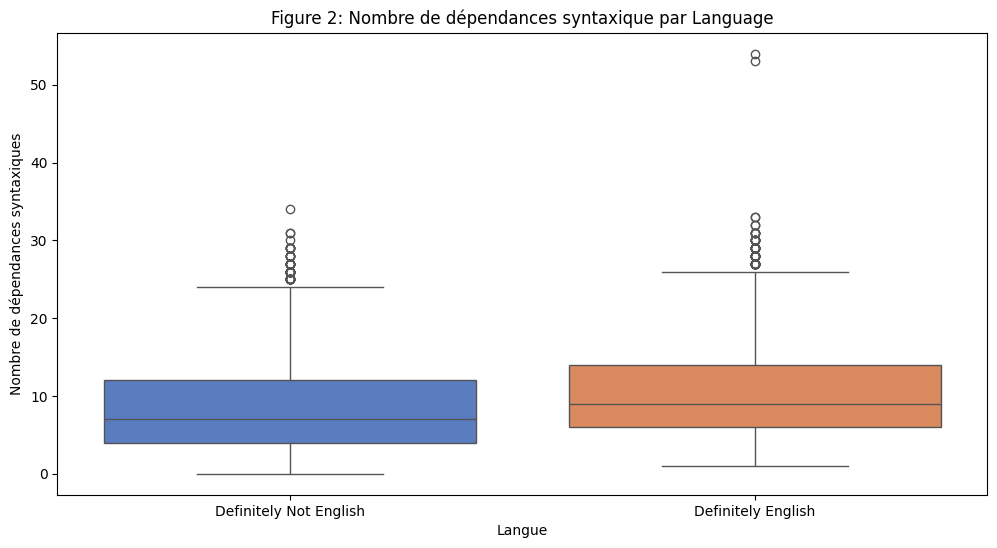

/var/folders/bd/qbh7t7450_g8p85v95frqnl40000gn/T/ipykernel_87209/2840773562.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


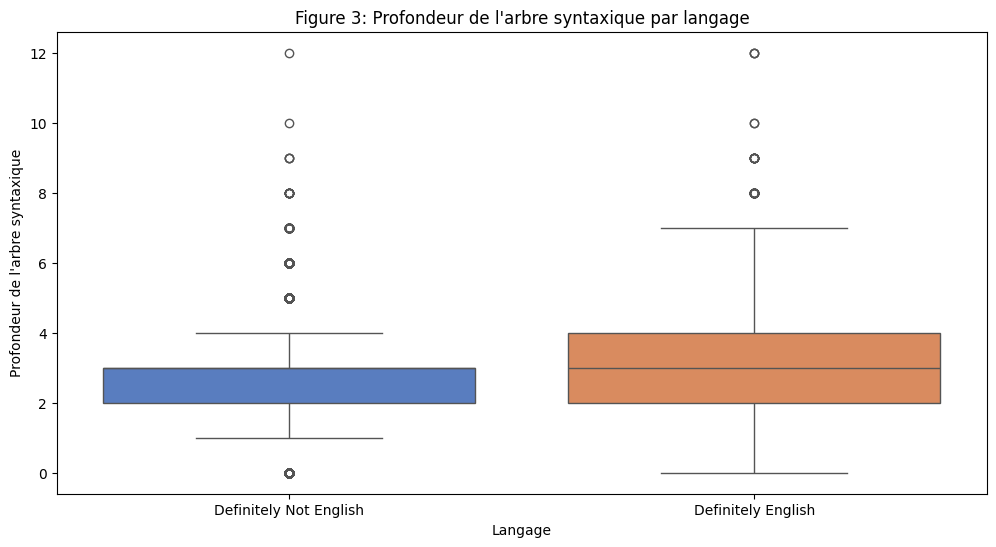

In [6]:
# Step 6: Compare syntactic complexity by language type
# On crée une colonne 'Language' pour catégoriser les tweets en "Definitely English" ou "Definitely Not English"
df["Language"] = df.apply(
    lambda row: "Definitely English" if row["Definitely English"] == 1 else "Definitely Not English", axis=1)

# On visualise la complexité syntaxique - Nombre de dépendances
plt.figure(figsize=(12, 6))
sns.boxplot(
    x="Language", y="dependency_count", data=df, palette="muted"
)
plt.title("Figure 2: Nombre de dépendances syntaxique par Language")
plt.ylabel("Nombre de dépendances syntaxiques")
plt.xlabel("Langue")
plt.show()

# On visualise la complexité syntaxique - Profondeur de l'arbre syntaxique
plt.figure(figsize=(12, 6))
sns.boxplot(
    x="Language", y="tree_depth", data=df, palette="muted"
)
plt.title("Figure 3: Profondeur de l'arbre syntaxique par langage")
plt.ylabel("Profondeur de l'arbre syntaxique")
plt.xlabel("Langage")
plt.show()


**Dependency Count** :  Les tweets en anglais (“Definitely English”) semblent avoir une légère tendance à un plus grand nombre de relations syntaxiques que ceux dans d’autres langues (“Definitely Not English”)

**Tree Depth** : Les tweets en anglais ont une profondeur syntaxique légèrement plus élevée en moyenne, indiquant une tendance à des structures syntaxiques un peu plus complexes que ceux des autres langues.

# 6. Modélisation des données

In [7]:
# On crée une fonction pour extraire des métriques syntaxiques
def calculate_syntax_metrics(text):
    """
    Calcule des métriques syntaxiques : nombre de dépendances et profondeur syntaxique.
    """
    if not text or text.strip() == "":
        return 0, 0
    
    doc = nlp(text) # On analyse le texte avec SpaCy
    
    # On compte les tokens comme nombre de dépendances
    dependency_count = len(doc)
    
    # On calcule la profondeur maximale des arbres syntaxiques
    tree_depth = max([len(list(token.ancestors)) for token in doc]) if doc else 0
    
    return dependency_count, tree_depth

# On ajoute les métriques au DataFrame
df['dependency_count'] = df['cleaned_text'].apply(lambda x: calculate_syntax_metrics(x)[0])
df['tree_depth'] = df['cleaned_text'].apply(lambda x: calculate_syntax_metrics(x)[1])

# On affiche un aperçu des nouvelles colonnes
print(df[['cleaned_text', 'dependency_count', 'tree_depth']].head())

                                        cleaned_text  dependency_count  \
0                          Bugün bulusmami lazimdiii                 3   
1     Volkan konak adami tribe sokar yemin ederim :D                 8   
2                                                Bed                 1   
3  I felt my first flash of violence at some fool...                20   
4            Ladies drink and get in free till 10:30                 8   

   tree_depth  
0           2  
1           3  
2           0  
3           6  
4           3  


   Definitely English  Definitely Not English                language
0                   0                       1  Definitely Not English
1                   0                       1  Definitely Not English
2                   1                       0      Definitely English
3                   1                       0      Definitely English
4                   1                       0      Definitely English


/var/folders/bd/qbh7t7450_g8p85v95frqnl40000gn/T/ipykernel_87209/3329645455.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='language', y='dependency_count', palette='muted')


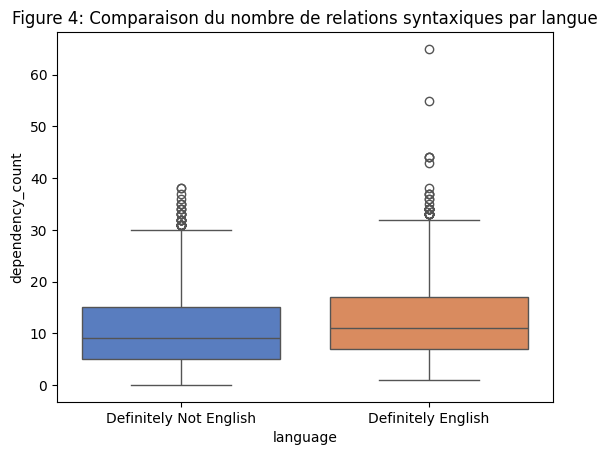

/var/folders/bd/qbh7t7450_g8p85v95frqnl40000gn/T/ipykernel_87209/3329645455.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='language', y='tree_depth', palette='muted')


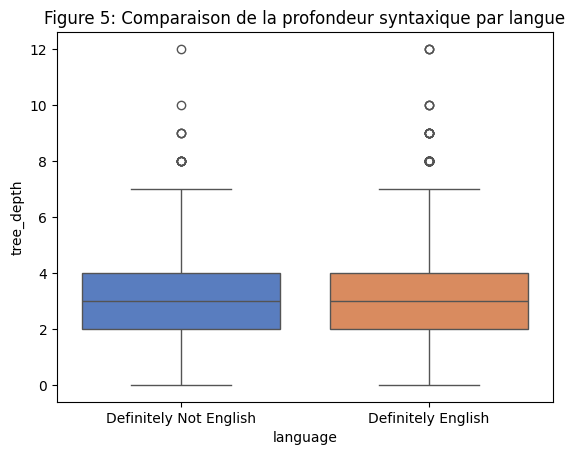

In [8]:
# On crée une colonne 'language' en fonction des valeurs des colonnes existantes
def classify_language(row):
    if row['Definitely English'] == 1:
        return 'Definitely English'
    elif row['Definitely Not English'] == 1:
        return 'Definitely Not English'

df['language'] = df.apply(classify_language, axis=1)

# On vérifie les premières lignes pour valider la colonne créée
print(df[['Definitely English', 'Definitely Not English', 'language']].head())

# On visualise les différences dans la complexité syntaxique (nombre de dépendances)
sns.boxplot(data=df, x='language', y='dependency_count', palette='muted')
plt.title('Figure 4: Comparaison du nombre de relations syntaxiques par langue')
plt.show()

# On visualise les différences dans la complexité syntaxique (profondeur syntaxique)
sns.boxplot(data=df, x='language', y='tree_depth', palette='muted')
plt.title('Figure 5: Comparaison de la profondeur syntaxique par langue')
plt.show()

**Comparaison du nombre de relation syntaxiques par langue** : Les tweets en anglais ont en moyenne un nombre de relations syntaxiques légèrement plus élevé que ceux qui ne sont pas en anglais, mais les deux distributions sont relativement similaires avec quelques valeurs aberrantes dans les deux cas.

**Comparaison de la profondeur syntaxique par langue** : La profondeur syntaxique des tweets en anglais et non anglais est très comparable, avec une distribution centrale presque identique et un nombre similaire de valeurs aberrantes.

# 7. Tests Statistiques 

In [9]:
# Sélection des métriques 'Tree depth' pour les deux catégories de langue
english_metrics = df[df['language'] == 'Definitely English']['tree_depth']
non_english_metrics = df[df['language'] == 'Definitely Not English']['tree_depth']

# Test de Mann-Whitney
stat, p = mannwhitneyu(english_metrics, non_english_metrics)
# On affiche les résultats
print(f"Statistique de Mann-Whitney pour 'Tree depth': {stat}")
print(f"p-valeur du test de Mann-Whitney pour 'Tree depth': {p}")

Statistique de Mann-Whitney pour 'Tree depth': 14955575.0
p-valeur du test de Mann-Whitney pour 'Tree depth': 8.867820432243203e-119


La **p-valeur** est extrêmement faible, ce qui veut dire que les différences observées dans les profondeurs d’arbre syntaxique (tree depth) entre les groupes (langues “Definitely English” et “Not English”) sont **statistiquement significatives**.

In [10]:
# On filtre les données pour les groupes "English" et "Not English"
english_dependency = df[df['language'] == 'Definitely English']['dependency_count']
not_english_dependency = df[df['language'] == 'Definitely Not English']['dependency_count']

# On effectue le test de Mann-Whitney pour 'dependency_count'
stat, p_value = mannwhitneyu(english_dependency, not_english_dependency, alternative='two-sided')

# On affiche les résultats 
print(f"Statistique de Mann-Whitney pour 'Dependency count': {stat}")
print(f"p-valeur du test de Mann-Whitney pour 'Dependency count': {p_value}")

Statistique de Mann-Whitney pour 'Dependency count': 13522501.0
p-valeur du test de Mann-Whitney pour 'Dependency count': 4.949285492228342e-35


La **p-valeur** est extrêmement faible, ce qui veut dire que les différences observées dans le nombre de relations syntaxiques (dependency count) entre les groupes (langues “Definitely English” et “Not English”) sont **statistiquement significatives**.

# 8.Conclusion

Cette analyse de la complexité syntaxique des tweets a permis d’explorer comment les contraintes imposées par le format limité à 280 caractères influencent la construction des phrases en anglais et dans d’autres langues. Deux métriques principales, le **nombre de relations syntaxiques** (dependency count) et la **profondeur syntaxique** (tree depth), ont été utilisées pour mesurer la complexité.

Les résultats montrent des différences significatives entre les tweets rédigés en anglais et ceux dans d’autres langues :

- **Pour le nombre de relations syntaxiques** (dependency count) : La p-valeur extrêmement faible indique une différence statistiquement significative. Cela suggère que les phrases en anglais et dans d’autres langues n’ont pas la même structure relationnelle, probablement en raison de différences linguistiques et grammaticales intrinsèques.

- **Pour la profondeur syntaxique** (tree depth) : La p-valeur confirme également une différence significative. Les phrases anglaises semblent avoir une complexité syntaxique moindre que celles des autres langues étudiées, ce qui pourrait refléter une tendance à privilégier des structures plus directes et concises sur Twitter.

Ces résultats soutiennent l’hypothèse selon laquelle la langue anglaise, souvent perçue comme plus concise, adopte des structures syntaxiques plus simples dans ce format limité. En revanche, certaines langues pourraient exploiter davantage de complexité syntaxique pour transmettre des idées dans la même contrainte de caractères.

Cette étude met en lumière comment les utilisateurs adaptent leur syntaxe en fonction du contexte numérique. Elle pourrait avoir des implications dans des domaines comme la traduction automatique, où il est essentiel de tenir compte des différences linguistiques pour reproduire la concision ou la richesse syntaxique d’un texte. Elle ouvre également la voie à des recherches supplémentaires sur l’impact des plateformes numériques sur l’évolution des pratiques linguistiques à une échelle mondiale.